In [2]:
import tarfile
import netCDF4 as nc
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import itertools

pywrdrb_dir = '../../Pywr-DRB/'
nwm_data_dir = '../../NWMv21/'
sys.path.append(pywrdrb_dir)

from pywrdrb.pywr_drb_node_data import nhm_site_matches, immediate_downstream_nodes_dict, obs_pub_site_matches

# Constants
cms_to_mgd = 22.82
cm_to_mg = 264.17/1e6
cfs_to_mgd = 0.64631688969744

In [6]:
### LOAD 
# Load DRB and GF geospatial
crs = 4386
drb = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
# gf = gpd.read_file(f'./GFv1.1.gdb/').to_crs(crs)
# gf_poi = gpd.read_file(f'./gfv11/gfv11.shp').to_crs(crs)

# Load NWM dataset 1970-2020
nwm_nwis = nc.Dataset(f'{nwm_data_dir}nwmv21_nwis.nc')

# Load unmanaged gauge metadata
unmanaged_gauge_metadata = pd.read_csv(f'../data/drb_unmanaged_usgs_metadata.csv')
Q_obs = pd.read_csv(f'../data/historic_unmanaged_streamflow_1900_2023_cms.csv', parse_dates=True, index_col=0)*cms_to_mgd

In [7]:
# Pull longitude and latitude
long = nwm_nwis['longitude'][:].data
lat = nwm_nwis['latitude'][:].data
feature_id = nwm_nwis['feature_id'][:].data
time_index = nwm_nwis['time'][:].data

# Find NWM points that match unmanaged gauges
nwm_gauge_matches = []
nwm_gauge_matches_idx = []
for i,id in enumerate(feature_id):
    if id in list(unmanaged_gauge_metadata['comid']):
        nwm_gauge_matches.append(id)
        nwm_gauge_matches_idx.append(i)
print(f'Found {len(nwm_gauge_matches)} NWM points that match unmanaged gauges')

Found 65 NWM points that match unmanaged gauges


In [8]:
# Pull out streamflow data
for i in nwm_gauge_matches_idx:
    if i == nwm_gauge_matches_idx[0]:
        nwm_gauge_data = pd.DataFrame(nwm_nwis['streamflow'][i,:].data*cms_to_mgd, index=time_index, columns=[feature_id[i]])
    else:
        nwm_gauge_data[feature_id[i]] = pd.DataFrame(nwm_nwis['streamflow'][i,:].data*cms_to_mgd, index=time_index)
        
# Aggregate to daily flow in MGD
# Default time is minutes singe 1970-01-01 00:00:00
datetime_index = pd.date_range(start='1979-02-01 00:00:00', end='2020-12-31', 
                               freq='D')
nwm_streamflow = pd.DataFrame(index=datetime_index, columns=nwm_gauge_data.columns)
for i,d in enumerate(datetime_index):
    nwm_streamflow.loc[d,:] = nwm_gauge_data.iloc[(i*24):(i*24+24),:].mean(axis=0)
nwm_streamflow.head(1)
    

,1748569,1748583,1748589,1748611,1748723,1748725,2588233,2589541,2590137,2590243,...,4780787,4780921,4781261,4782009,4783101,4784831,8075192,8076762,8077030,9481686
1979-02-01,5.705,88.070946,22.82,15.688748,15.688748,9.56776,19.967499,18.54125,51.701557,0.0,...,8.5575,43.916615,32.328335,4.27875,31.377497,1158.293335,5.526718,18.422396,1.42625,7.012395


In [13]:
unmanaged_gauge_metadata.loc[unmanaged_gauge_metadata['comid'] == 1748589]['site_no']

120    1415000
Name: site_no, dtype: int64

In [30]:
test_comid = 2590137
test_meta = unmanaged_gauge_metadata.loc[unmanaged_gauge_metadata['comid'] == test_comid]
test_q = Q_obs.loc['1985-02-01':'2020-12-31',f'USGS-0{test_meta["site_no"].values[0]}']
test_nwm = nwm_streamflow.loc['1985-02-01':'2020-12-31',test_comid]

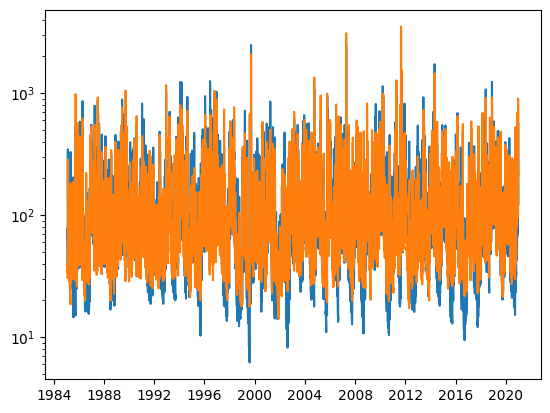

In [31]:
fig,ax = plt.subplots()
ax.plot(test_q)
ax.plot(test_nwm)
plt.yscale('log')

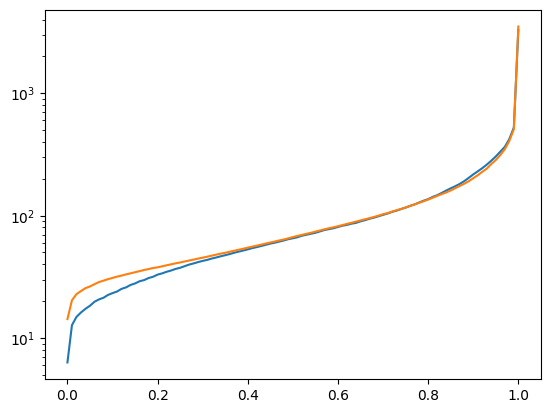

In [32]:
fdc_quantiles = np.linspace(0.0001,1,101)
obs_fdc = np.quantile(test_q, fdc_quantiles)
nwm_fdc = np.quantile(test_nwm, fdc_quantiles)

fig,ax = plt.subplots()
ax.plot(fdc_quantiles, obs_fdc)
ax.plot(fdc_quantiles, nwm_fdc)
plt.yscale('log')